In [1]:
import numpy as np
import random
from matplotlib import pyplot, transforms
from scipy.signal import argrelextrema, find_peaks, convolve
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import ipywidgets as widgets
from IPython.display import display, clear_output
import cmastro
import itertools
import colorsys
import sk_dsp_comm.sigsys as ss
from numba import vectorize, float64, njit, prange
from joblib import Parallel, delayed
import cProfile
import pstats
from io import StringIO
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

In [2]:
sqrt = np.sqrt
pi = np.pi
exp = np.exp
sin = np.sin
cos = np.cos
mu0 = pi*4e-7 # permeability [H/m]

def findNearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]

def filter_negWaveVectors(M_yx):
    M_kq =  np.fft.fft2(M_yx) 
    kLen = int(M_kq.shape[1]/2+1)
    zeros = np.zeros( (M_kq.shape[0], kLen))
    M_kq[:,:kLen] = zeros
    M_yx_filtered = np.fft.ifft2(M_kq)
    M_yx_filtered /= np.amax(np.abs(M_yx_filtered[:, int(M_yx_filtered.shape[1]/2+100)]))
    return M_yx_filtered

def colourMode(mod, phase):
    mod = mod/np.amax(mod)
    array1 = np.zeros((phase.shape[0], phase.shape[1], 3))
    for y in range(phase.shape[0]):
        for x in range(phase.shape[1]):
            h = 0.5+phase[y,x]/(2*np.pi)  # angle
            l, s = (mod[y,x]), 1
            array1[y,x] = np.array(colorsys.hls_to_rgb(h, l, s))
    return array1

def kalDR(k, angle_z, angle_k, d, mu0H0eff, wM, lb, mu0Ha, gamma):
    mu0 = np.pi*4e-07
    w0 = gamma*mu0H0eff + gamma*mu0Ha +  gamma*lb*k**2
    
    def Fcoef1(k, theta, phi, w0):
        P = 1 - (1-exp(-k*d))/(k*d)
        return P+(sin(theta)**2) *(1-P*(1+cos(phi)**2) +  sin(phi)**2*  P*(1-P) * wM/w0)
    w2 = w0*(w0 + wM*Fcoef1(k, angle_z, angle_k, w0) )
    return np.sqrt(w2)/(2*np.pi)

def gedDT(times):
    xdata = range(len(times))
    from scipy.optimize import curve_fit
    def func(x, a, b):
        return a * x + b
    dt=np.abs(times[-1]-times[1])/(len(times)-1)
    popt, pcov = curve_fit(func, xdata, times, p0=[dt,0])
    plt.plot(xdata, times)
    plt.plot(xdata, func(xdata, *popt))
    return popt[0]

npzfile_oop = np.load('point_source_yig//point_source_2600_MHz_200_mT_OOP.npz')
print(sorted(npzfile_oop.files))

M_oop = npzfile_oop['M']
cx_oop = npzfile_oop['cx']
cy_oop = npzfile_oop['cy']

print(M_oop.shape)

pointSrc_oop = filter_negWaveVectors(M_oop.copy())
pointSrc_oop = pointSrc_oop[:, int(pointSrc_oop.shape[1]/2):]

y_int = np.arange(pointSrc_oop.shape[0])

def aperture_func(l, s, n, w2):
    '''
    l - width of a waveguide
    s - aperture width
    n - number of apertures
    w2 - shift of the apertures
    '''
    d = int(l/n)
    y_int = np.arange(0, l, 1)
    g_in = ss.rect(np.mod(y_int, d)-d/2, s)

    src = []
    for i in range(int(np.floor(l/d))):
            source_n = (i-1)*d+d/2-s/2
            src.append(source_n)

    shift_src = 0
    g_in_an = np.zeros_like(y_int).astype(complex)

    for i in range(len(y_int)):
        if y_int[i] <= w2 or y_int[i] >= l - w2:
            Amp = 0
        else:
            Amp = 1
        if y_int[i] >= src[shift_src] and y_int[i] <= src[shift_src] + s:
            phi_t = pi/4
        else:
            phi_t = 0
        g_in_an[i] = Amp*g_in[i]*exp(1j*phi_t)
    return g_in_an

def talbot_length(d,lam):
    '''
    d - distance between the sources [nm]
    lam - wavelength [nm]
    '''
    return 2*d**2/lam

['M', 'cx', 'cy']
(3000, 3000)


In [3]:
def convolve_column(pointSrc_col, g_in):
    return np.convolve(pointSrc_col, g_in, mode='full')

def logic_oop(number_of_sources, distance_between_apertures, aperture_width, changed_src_numbers, 
              shift, amplitude, axhline, threshhold, w_axhl, plots=True, one_d_phase=True):
    
    if(distance_between_apertures % 15 != 0 or aperture_width % 15 != 0 or axhline % 15 != 0):
        raise ValueError("All length parameters must be divisible by 15, because the unit cell is 15 nm.")

    pointSrc0 = filter_negWaveVectors(M_oop.copy())
    pointSrc0 = pointSrc0[:, int(pointSrc0.shape[1] / 2):]
    
    d = distance_between_apertures / 15
    s = aperture_width / 15
    n = number_of_sources
    width = d * n
    y_int = np.arange(0, width, 1)

    # Rectangular function
    g_in = ss.rect(np.mod(y_int, d)-d/2, s)
    
    g_in_an = np.zeros_like(y_int, dtype=complex)
    b = 1
    
    for i in range(len(y_int)):
        if g_in[i] == 1 and (b in changed_src_numbers):
            phi_t = shift
            Amp = amplitude
            if g_in[i + 1] == 0:
                b += 1
        elif g_in[i] == 1:
            phi_t = 0
            Amp = 1
            if g_in[i + 1] == 0:
                b += 1
        else:
            phi_t = 0
            Amp = 1
        
        g_in_an[i] = Amp * g_in[i] * np.exp(1j * phi_t)

    g_in = g_in_an
    pointSrc = pointSrc0.copy()
    
    # Parallel Convolution
    newField_list = Parallel(n_jobs=-1)(delayed(convolve_column)(pointSrc[:, i], g_in) for i in range(pointSrc.shape[1]))
    newField = np.array(newField_list).T
    
    axhl = int(axhline / 15)
    newField /= np.amax(np.abs(newField))
    newField2 = np.abs(newField) ** 2
    newField = newField[int(pointSrc.shape[0] / 2):-int(pointSrc.shape[0] / 2), :]
    newField2 = newField2[int(pointSrc.shape[0] / 2):-int(pointSrc.shape[0] / 2), :]
    newField = newField[:, :axhl + 300]
    newField2 = newField2[:, :axhl + 300]
    
    g_in, arr_in, intensity = g_in, newField, newField2
    
    phase_2plot = np.angle(newField)
    mod_2plot = np.abs(newField)
    
    arr_2plot = np.real(arr_in).copy()
    arr_2plot /= np.amax(np.abs(arr_2plot[:, 20:]))
    int_2plot = intensity.copy()
    int_2plot /= np.amax(np.abs(int_2plot[:, 20:]))
    
    norm_re = colors.Normalize(vmin=-0.5, vmax=0.5)
    norm_int = colors.Normalize(vmin=0, vmax=1)
    cmap = "RdGy_r"
    color_phi = 'maroon'
    x_int, amplitude, phase = y_int, np.abs(g_in), np.angle(g_in) * 180 / np.pi
    amplitude /= np.amax(amplitude)
    sh = arr_2plot.shape
    y_li = np.arange(0, sh[0] * cy_oop, cy_oop) * 1e09
    x_li = np.arange(0, sh[1] * cx_oop, cx_oop) * 1e09
    
    intentsity_1d_x = np.arange(0, sh[0], 1)
    int_avg = np.mean(int_2plot[:, axhl - w_axhl:axhl + w_axhl], axis=1)
    phase_1d_x = np.arange(0, sh[0], 1)
    phase_1d = phase_2plot[:, axhl]
    max_i = find_peaks(int_avg, height=threshhold)[0]

    truth_table = []
    for i in range(n):
        if any(np.abs(i * d - max_j) < 12 for max_j in max_i):
            truth_table.append(1)
        else:
            truth_table.append(0) 
    
    
    if plots:
        f, ax = plt.subplots(2, 2, gridspec_kw={'height_ratios': [1, 4]}, sharex=True, figsize=(12, 5))

        ax[0, 0].plot(x_int * 15, amplitude, color='k')
        ax[0, 0].fill_between(x_int * 15, 0, amplitude, color='#CCCCCC')
        ax[0, 0].set_ylim(-0.1, 1.1)
        ax[0, 0].set_ylabel("Ampl. (a.u.)")
        ax0a = ax[0, 0].twinx()
        ax0a.plot(x_int * 15, phase, color=color_phi, ls='-', lw=4)
        ax0a.tick_params(axis='y', labelcolor=color_phi)
        ax0a.set_ylabel("Phase (°)", color=color_phi)
        ax0a.set_ylim(-190, 190)
        ax0a.set_yticks(range(-180, 190, 90))
        
        ax[1, 0].imshow(colourMode(mod_2plot.T, phase_2plot.T), aspect='equal', interpolation='sinc', 
                        extent=[y_li[0], y_li[-1], x_li[-1], x_li[0]])
        ax[1, 0].set_xlabel("x (nm)")
        ax[1, 0].set_ylabel("y (nm)")
        
        ax[0, 1].plot(intentsity_1d_x * 15, int_avg, linewidth=3, color='blue')
        ax[0, 1].set_ylabel("Ampl. (a.u.)")
        ax[0, 1].axhline(threshhold, color='orange', ls='--')
        
        for j in max_i:
            ax[0, 1].scatter(j * 15, int_avg[j], zorder=3, color='red')
        
        ax[1, 1].imshow(int_2plot.T, norm=norm_int, aspect='equal', 
                        extent=[y_li[0], y_li[-1], x_li[-1], x_li[0]])
        ax[1, 1].axhline(axhline, color='red', lw=w_axhl, alpha=0.4)
        ax[1, 1].set_xlabel("x (nm)")
        ax[1, 1].set_ylabel("y (nm)")
        
        if one_d_phase:
            ax0b = ax[0, 1].twinx()
            ax0b.plot(phase_1d_x * 15, phase_1d * 180 / np.pi, linewidth=1, color=color_phi)
            ax0b.set_ylabel("Phase (°)", color=color_phi)
            ax0b.set_ylim(-190, 190)
            ax0b.set_yticks(range(-180, 190, 90))
            ax0b.tick_params(axis='y', labelcolor=color_phi)
            
        plt.tight_layout()
        plt.show()
    
    return truth_table

lam = 230.24 # nm
zT = np.round(talbot_length(1440,lam),2)
zT = 15*np.floor(zT/15)
print('zT =',zT,'nm')

zT = 18000.0 nm


In [4]:
logic_oop(10, 1440, 240, [2,6,7,8], pi/2, 1, zT/2-900, 0.45, 5, False, False)
# 1) number of inputs
# 2) distance between inputs [nm]
# 3) inputs width [nm]
# 4) number of input to change (if 0 -> None)
# 5) phase chage of the chosen input [rad]
# 6) amplitude change of the chosen input (if 1 -> unchanged)
# 7) distance from inputs to analysis (#outputs = #inputs-1) [nm]
# 8) threshhold amplitude (a.u. -> from 0 to 1)
# 9) display plots (True) or just a truth table (False)
# 10) display phase in 1D (True) or not (False)

[0, 0, 0, 0, 1, 1, 1, 0, 1, 0]

# Digit Presence Classification

C:\Users\MateuszG\AppData\Local\Temp/ipykernel_4112/785632369.py:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(X), np.array(y)


Decision Tree Accuracy: 87.50%
Random Forest Accuracy: 90.40%
SVM Accuracy: 78.10%
32/32 [==============================] - 0s 516us/step
Neural Network Accuracy: 75.50%


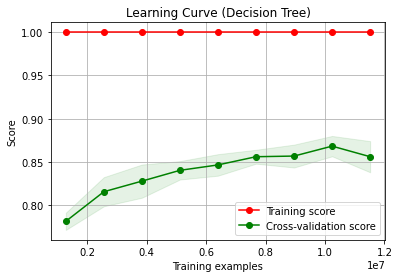

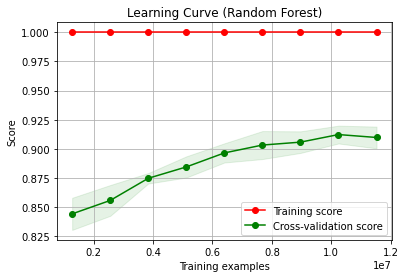

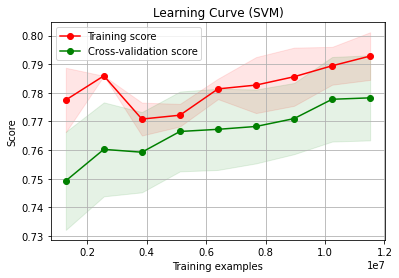

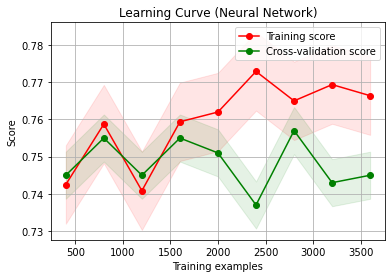

In [5]:
import numpy as np
import random
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

# Function to generate synthetic data for digit presence classification
def generate_data_digit_presence(num_samples, digit):
    X = []
    y = []
    for _ in range(num_samples):
        # Ensure size does not exceed the range (10)
        input_array = np.random.choice(range(10), size=random.randint(1, 10), replace=False)
        output_array = logic_oop(10, 1440, 240, input_array, np.pi/2, 1, zT/2-900, 0.45, 5, False, False)
        X.append(input_array)
        label = 1 if digit in input_array else 0  # Label: 1 if digit is present, 0 otherwise
        y.append(label)
    return np.array(X), np.array(y)

# Generate data for digit presence classification
digit_to_detect = 5
X, y = generate_data_digit_presence(5000, digit_to_detect)  # Generate 100 samples

# Preprocess data: pad input arrays to ensure they all have the same length (10)
X = np.array([np.pad(sample, (0, 10 - len(sample)), 'constant') for sample in X])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize different classification models
models = {
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42)
}

# Function to create and compile a Keras model for neural network classification
def create_keras_model():
    model = Sequential([
        Dense(32, activation='relu', input_shape=(10,)),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')  # Single output neuron for binary classification
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Create and compile the Keras model
neural_network = create_keras_model()

# Train and evaluate models
for name, model in models.items():
    model.fit(X_train, y_train.ravel())  # Ensure y_train is 1D
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy * 100:.2f}%")

# Train the neural network
neural_network.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
y_pred_nn = neural_network.predict(X_test)
y_pred_nn = (y_pred_nn > 0.5).astype(int)  # Convert probabilities to binary predictions
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"Neural Network Accuracy: {accuracy_nn * 100:.2f}%")

# Function to plot learning curves
def plot_learning_curve(model, title, X_train, y_train):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train.ravel(), cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 0.9, 9)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(f"Learning Curve ({title})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.grid()

    plt.fill_between(train_sizes * len(X_train), train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes * len(X_train), test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes * len(X_train), train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes * len(X_train), test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Plot learning curves for each scikit-learn model
for name, model in models.items():
    plot_learning_curve(model, name, X_train, y_train)

# Manually create learning curves for the neural network
train_sizes = np.linspace(0.1, 0.9, 9)
train_scores = []
test_scores = []
train_scores_std = []
test_scores_std = []

for train_size in train_sizes:
    X_train_partial, _, y_train_partial, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
    neural_network = create_keras_model()  # Reinitialize the model
    neural_network.fit(X_train_partial, y_train_partial, epochs=10, batch_size=32, verbose=0)
    
    train_score = neural_network.evaluate(X_train_partial, y_train_partial, verbose=0)[1]
    test_score = neural_network.evaluate(X_test, y_test, verbose=0)[1]
    
    train_scores.append(train_score)
    test_scores.append(test_score)

train_scores = np.array(train_scores)
test_scores = np.array(test_scores)
train_scores_std = np.std(train_scores, axis=0)
test_scores_std = np.std(test_scores, axis=0)

plt.figure()
plt.title(f"Learning Curve (Neural Network)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes * len(X_train), train_scores - train_scores_std, train_scores + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes * len(X_train), test_scores - test_scores_std, test_scores + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes * len(X_train), train_scores, 'o-', color="r", label="Training score")
plt.plot(train_sizes * len(X_train), test_scores, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

In [9]:
def visualize_predictions(model, model_name, digit_to_detect, num_examples=5):
    print(f"Predictions for {model_name}:")
    for _ in range(num_examples):
        input_array = np.random.choice(range(10), size=np.random.randint(1, 11), replace=False)
        output_array = logic_oop(10, 1440, 240, input_array, pi/2, 1, zT/2-900, 0.45, 5, False, False)
        prediction = model.predict([output_array])[0]
        actual = 1 if digit_to_detect in input_array else 0
        
        print(f"Input array: {input_array}")
        print(f"Output array (features): {output_array}")
        print(f"Actual presence of digit '{digit_to_detect}': {actual}")
        print(f"Predicted presence of digit '{digit_to_detect}': {prediction}")
        print("-" * 50)

# Visualize predictions for digit '3' for each model
for name, model in models.items():
    print(f"{name} Predictions:")
    visualize_predictions(model, name, digit_to_detect, num_examples=5)

Decision Tree Predictions:
Predictions for Decision Tree:
Input array: [8]
Output array (features): [0, 0, 1, 1, 1, 1, 1, 1, 0, 0]
Actual presence of digit '5': 0
Predicted presence of digit '5': 1
--------------------------------------------------
Input array: [8 3 2 9 5 4]
Output array (features): [0, 1, 1, 1, 1, 0, 1, 0, 0, 0]
Actual presence of digit '5': 1
Predicted presence of digit '5': 1
--------------------------------------------------
Input array: [3 1 8 5 7]
Output array (features): [0, 0, 1, 0, 0, 1, 1, 1, 0, 0]
Actual presence of digit '5': 1
Predicted presence of digit '5': 1
--------------------------------------------------
Input array: [3 9 7]
Output array (features): [0, 0, 1, 1, 1, 0, 1, 1, 0, 0]
Actual presence of digit '5': 0
Predicted presence of digit '5': 1
--------------------------------------------------
Input array: [3 4 9]
Output array (features): [0, 0, 0, 0, 1, 1, 0, 1, 1, 0]
Actual presence of digit '5': 0
Predicted presence of digit '5': 0
------------

32/32 [==============================] - 0s 581us/step


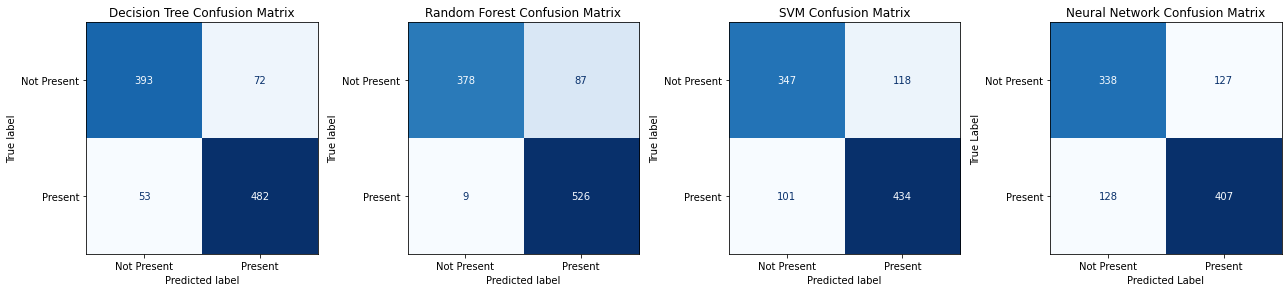

32/32 [==============================] - 0s 518us/step


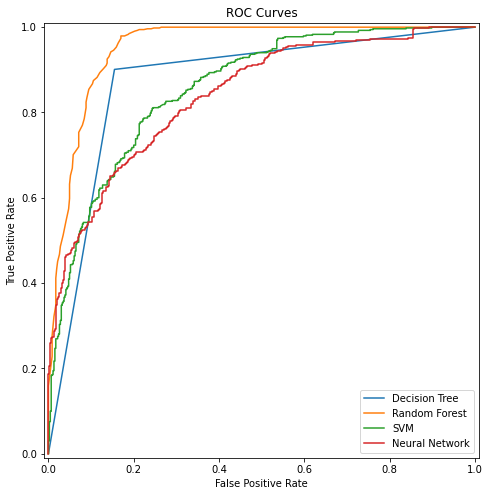

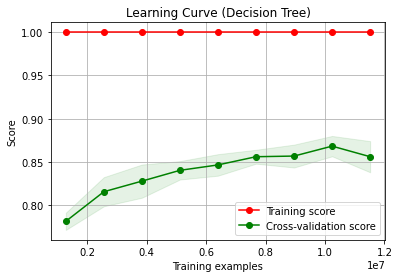

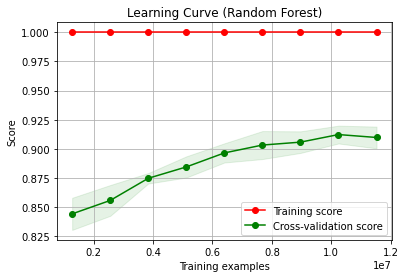

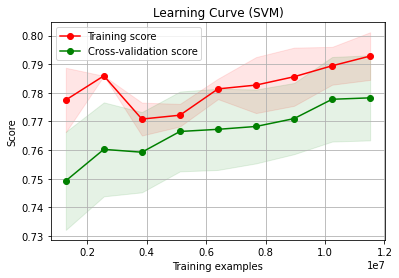

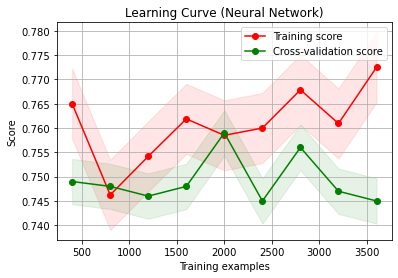

In [11]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay

# Plot confusion matrices
plt.figure(figsize=(18, 6))
for i, (name, model) in enumerate(models.items()):
    plt.subplot(1, 4, i+1)
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(conf_matrix, display_labels=["Not Present", "Present"]).plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)
    plt.title(f"{name} Confusion Matrix")

# Plot confusion matrix for neural network
plt.subplot(1, 4, 4)
y_pred_nn = neural_network.predict(X_test)
y_pred_nn = (y_pred_nn > 0.5).astype(int)
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)
ConfusionMatrixDisplay(conf_matrix_nn, display_labels=["Not Present", "Present"]).plot(cmap=plt.cm.Blues, ax=plt.gca(), colorbar=False)
plt.title("Neural Network Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Plot ROC curves
plt.figure(figsize=(12, 8))
for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    RocCurveDisplay(fpr=fpr, tpr=tpr, estimator_name=name).plot(ax=plt.gca())
y_prob_nn = neural_network.predict(X_test).ravel()
fpr_nn, tpr_nn, _nn = roc_curve(y_test, y_prob_nn)
RocCurveDisplay(fpr=fpr_nn, tpr=tpr_nn, estimator_name='Neural Network').plot(ax=plt.gca())
plt.title("ROC Curves")
plt.show()

# Plot learning curves
for name, model in models.items():
    plot_learning_curve(model, name, X_train, y_train)

# Manually create learning curves for the neural network
train_sizes = np.linspace(0.1, 0.9, 9)
train_scores = []
test_scores = []
train_scores_std = []
test_scores_std = []

for train_size in train_sizes:
    X_train_partial, _, y_train_partial, _ = train_test_split(X_train, y_train, train_size=train_size, random_state=42)
    neural_network = create_keras_model()  # Reinitialize the model
    neural_network.fit(X_train_partial, y_train_partial, epochs=10, batch_size=32, verbose=0)
    
    train_score = neural_network.evaluate(X_train_partial, y_train_partial, verbose=0)[1]
    test_score = neural_network.evaluate(X_test, y_test, verbose=0)[1]
    
    train_scores.append(train_score)
    test_scores.append(test_score)

train_scores = np.array(train_scores)
test_scores = np.array(test_scores)
train_scores_std = np.std(train_scores, axis=0)
test_scores_std = np.std(test_scores, axis=0)

plt.figure()
plt.title(f"Learning Curve (Neural Network)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes * len(X_train), train_scores - train_scores_std, train_scores + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes * len(X_train), test_scores - test_scores_std, test_scores + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes * len(X_train), train_scores, 'o-', color="r", label="Training score")
plt.plot(train_sizes * len(X_train), test_scores, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()


In [14]:
import numpy as np
import pandas as pd

def generate_example_data(num_samples, digit):
    data = []
    for _ in range(num_samples):
        input_array = np.random.choice(range(10), size=np.random.randint(1, 11), replace=False)
        output_array = logic_oop(10, 1440, 240, input_array, np.pi/2, 1, zT/2-900, 0.45, 5, False, False)
        label = 1 if digit in input_array else 0
        data.append({
            "input_array": input_array,
            "output_array": output_array,
            "label": label
        })
    return data

# Generate artificial example data
digit = 5
num_samples = 40
example_data = generate_example_data(num_samples, digit)

# Convert to DataFrame for better visualization
df = pd.DataFrame(example_data)

# Display the DataFrame
print(df)


                       input_array                    output_array  label
0                              [5]  [0, 0, 1, 1, 1, 1, 1, 1, 0, 0]      1
1                  [4, 2, 3, 5, 6]  [0, 0, 1, 1, 1, 1, 1, 1, 0, 0]      1
2      [0, 5, 7, 1, 4, 9, 6, 2, 8]  [0, 0, 0, 0, 1, 1, 1, 1, 0, 0]      1
3            [4, 5, 9, 1, 3, 2, 0]  [0, 0, 1, 1, 1, 0, 0, 0, 0, 0]      1
4                           [0, 2]  [0, 0, 0, 1, 1, 1, 1, 1, 1, 0]      0
5                  [0, 1, 5, 8, 3]  [0, 0, 0, 1, 0, 1, 1, 1, 0, 0]      1
6                           [4, 8]  [0, 0, 1, 1, 1, 1, 1, 0, 1, 0]      0
7               [7, 4, 0, 3, 2, 1]  [0, 0, 1, 1, 1, 1, 0, 1, 1, 0]      0
8   [6, 5, 3, 9, 4, 0, 2, 1, 7, 8]  [0, 0, 1, 1, 1, 1, 1, 1, 0, 0]      1
9         [4, 2, 3, 9, 8, 5, 0, 6]  [0, 0, 1, 1, 1, 1, 1, 0, 0, 0]      1
10                    [1, 8, 2, 7]  [0, 0, 1, 1, 0, 1, 1, 0, 0, 0]      0
11                             [9]  [0, 0, 1, 1, 1, 1, 1, 1, 0, 0]      0
12  [4, 5, 1, 8, 0, 2, 3, 6, 9, 7]  [0

## methods comparison

In [29]:
# Arrays to store accuracy for each number of samples
num_samples_range = range(10, 101, 10)
results = {name: [] for name in models.keys()}

# Loop over different number of samples
for num_samples in num_samples_range:
    print(f"\nNumber of samples: {num_samples}")
    
    # Generate data
    digit = 3
    X, y = generate_data_digit_presence(num_samples, digit)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train and evaluate each model
    for name, model in models.items():
        if name == 'Neural Network':
            # One-hot encode the labels for neural network
            y_train_nn = to_categorical(y_train, 2)
            y_test_nn = to_categorical(y_test, 2)
            model.fit(X_train, y_train_nn, epochs=10, batch_size=32, verbose=0)
            y_pred = np.argmax(model.predict(X_test), axis=1)
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        results[name].append(accuracy)
        print(f"{name} Accuracy: {accuracy * 100:.2f}%")

# Plot the results
plt.figure()
for name, accuracies in results.items():
    plt.plot(num_samples_range, accuracies, label=name)

plt.title('Model Accuracy as a Function of Number of Samples')
plt.xlabel('Number of Samples')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


Number of samples: 10
Decision Tree Accuracy: 50.00%
Random Forest Accuracy: 50.00%
SVM Accuracy: 50.00%
1/1 [==============================] - 0s 30ms/step
Neural Network Accuracy: 50.00%

Number of samples: 20
Decision Tree Accuracy: 50.00%
Random Forest Accuracy: 50.00%
SVM Accuracy: 50.00%
1/1 [==============================] - 0s 31ms/step
Neural Network Accuracy: 0.00%

Number of samples: 30
Decision Tree Accuracy: 50.00%
Random Forest Accuracy: 50.00%
SVM Accuracy: 50.00%
1/1 [==============================] - 0s 26ms/step
Neural Network Accuracy: 66.67%

Number of samples: 40


# Even vs. Odd Majority Classification

In [9]:
# synthetic data
def generate_data_even_odd(num_samples):
    X = []
    y = []
    for _ in range(num_samples):
        input_array = np.random.choice(range(10), size=np.random.randint(1, 11), replace=False)
        output_array = logic_oop(10, 1440, 240, input_array, pi/2, 1, zT/2-900, 0.45, 5, False, False)
        X.append(output_array)
        # Example classification task: majority of input numbers are even or odd
        even_count = sum(1 for num in input_array if num % 2 == 0)
        odd_count = len(input_array) - even_count
        label = 1 if even_count > odd_count else 0  # Label: 1 if majority even, 0 if majority odd
        y.append(label)
    return np.array(X), np.array(y)

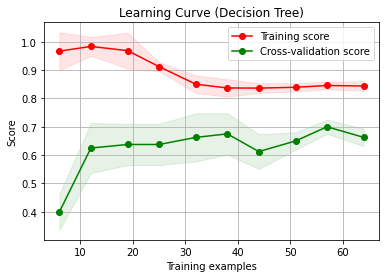

Decision Tree Accuracy: 65.00%
Confusion Matrix:
 [[11  4]
 [ 3  2]]
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.73      0.76        15
           1       0.33      0.40      0.36         5

    accuracy                           0.65        20
   macro avg       0.56      0.57      0.56        20
weighted avg       0.67      0.65      0.66        20



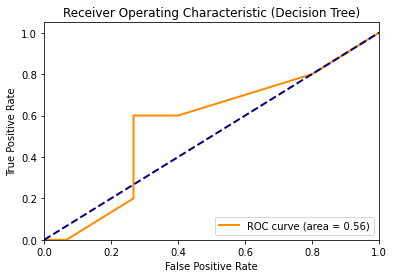

Neural Network Accuracy: 75.00%
Confusion Matrix (NN):
 [[12  3]
 [ 2  3]]
Classification Report (NN):
               precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.50      0.60      0.55         5

    accuracy                           0.75        20
   macro avg       0.68      0.70      0.69        20
weighted avg       0.77      0.75      0.76        20



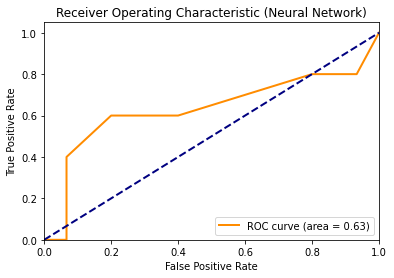

In [10]:
# Generate dataset
X, y = generate_data_even_odd(100)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree model
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Plot learning curve for Decision Tree
train_sizes, train_scores, test_scores = learning_curve(
    decision_tree_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve (Decision Tree)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

plt.legend(loc="best")
plt.show()

# Fit the Decision Tree model
decision_tree_model.fit(X_train, y_train)

# Predict and evaluate the Decision Tree model
y_pred = decision_tree_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy * 100:.2f}%")

# Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test, y_pred))

# ROC Curve and AUC for Decision Tree
fpr, tpr, _ = roc_curve(y_test, decision_tree_model.predict_proba(X_test)[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Decision Tree)')
plt.legend(loc="lower right")
plt.show()

# Initialize and train a simple Neural Network model for comparison
nn_model = MLPClassifier(hidden_layer_sizes=(10,), max_iter=1000, random_state=42)
nn_model.fit(X_train, y_train)

# Predict and evaluate the Neural Network model
y_pred_nn = nn_model.predict(X_test)
accuracy_nn = accuracy_score(y_test, y_pred_nn)
print(f"Neural Network Accuracy: {accuracy_nn * 100:.2f}%")

# Confusion Matrix and Classification Report for Neural Network
conf_matrix_nn = confusion_matrix(y_test, y_pred_nn)
print("Confusion Matrix (NN):\n", conf_matrix_nn)
print("Classification Report (NN):\n", classification_report(y_test, y_pred_nn))

# ROC Curve and AUC for Neural Network
fpr_nn, tpr_nn, _nn = roc_curve(y_test, nn_model.predict_proba(X_test)[:, 1])
roc_auc_nn = auc(fpr_nn, tpr_nn)

plt.figure()
plt.plot(fpr_nn, tpr_nn, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_nn:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Neural Network)')
plt.legend(loc="lower right")
plt.show()


In [11]:
new_input = np.array([6,2,0,4])  # Example input array with unique integers
new_output = logic_oop(10, 1440, 240, new_input, pi/2, 1, zT/2-900, 0.45, 5, False, False)
prediction = decision_tree_model.predict([new_output])

print(f"New input: {new_input}")
print(f"New output (from logic_oop): {new_output}")
print(f"Prediction (1 for majority even, 0 for majority odd): {prediction[0]}")

New input: [6 2 0 4]
New output (from logic_oop): [0, 0, 0, 1, 1, 1, 1, 1, 1, 0]
Prediction (1 for majority even, 0 for majority odd): 1


# Prime vs. Composite Majority Classification

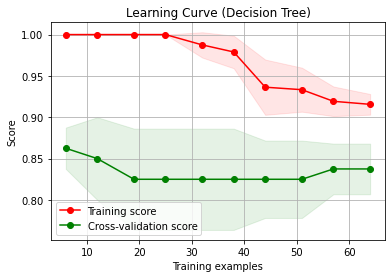

Accuracy: 70.00%


In [12]:
def is_prime(n):
    if n < 2:
        return False
    for i in range(2, int(np.sqrt(n)) + 1):
        if n % i == 0:
            return False
    return True

def generate_data_prime(num_samples):
    X = []
    y = []
    for _ in range(num_samples):
        input_array = np.random.choice(range(10), size=np.random.randint(1, 11), replace=False)
        output_array = logic_oop(10, 1440, 240, input_array, np.pi/2, 1, zT/2-900, 0.45, 5, False, False)
        X.append(output_array)
        prime_count = sum(1 for num in input_array if is_prime(num))
        composite_count = len(input_array) - prime_count
        label = 1 if prime_count > composite_count else 0  # Label: 1 if majority prime, 0 if majority composite
        y.append(label)
    return np.array(X), np.array(y)

# Generate data
X, y = generate_data_prime(100)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model_prime
model_prime = DecisionTreeClassifier(random_state=42)
model_prime.fit(X_train, y_train)

train_sizes, train_scores, test_scores = learning_curve(
    model_prime, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Learning Curve (Decision Tree)")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.grid()

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

# Fit the model_prime
model_prime.fit(X_train, y_train)

# Predict and evaluate the model_prime
y_pred = model_prime.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")

# Sum Threshold Classification

In [14]:
def generate_data_sum_threshold(num_samples, threshold):
    X = []
    y = []
    for _ in range(num_samples):
        input_array = np.random.choice(range(10), size=np.random.randint(1, 11), replace=False)
        output_array = logic_oop(10, 1440, 240, input_array, np.pi/2, 1, zT/2-900, 0.45, 5, False, False)
        X.append(output_array)
        label = 1 if np.sum(input_array) > threshold else 0  # Label: 1 if sum > threshold, 0 otherwise
        y.append(label)
    return np.array(X), np.array(y)

# Generate data
threshold = 30
X, y = generate_data_sum_threshold(100, threshold)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model_sum_threshold
model_sum_threshold = DecisionTreeClassifier(random_state=42)
model_sum_threshold.fit(X_train, y_train)

# Predict and evaluate the model_sum_threshold
y_pred = model_sum_threshold.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 65.00%


# Mean Classification

In [16]:
def generate_data_mean_threshold(num_samples, mean_threshold):
    X = []
    y = []
    for _ in range(num_samples):
        input_array = np.random.choice(range(10), size=np.random.randint(1, 11), replace=False)
        output_array = logic_oop(10, 1440, 240, input_array, np.pi/2, 1, zT/2-900, 0.45, 5, False, False)
        X.append(output_array)
        label = 1 if np.mean(input_array) > mean_threshold else 0  # Label: 1 if mean > threshold, 0 otherwise
        y.append(label)
    return np.array(X), np.array(y)

# Generate data
mean_threshold = 4.5
X, y = generate_data_mean_threshold(1000, mean_threshold)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model_mean_threshold
model_mean_threshold = DecisionTreeClassifier(random_state=42)
model_mean_threshold.fit(X_train, y_train)

# Predict and evaluate the model_mean_threshold
y_pred = model_mean_threshold.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 68.00%


# 3x3 binary matrices

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical

def generate_data_logic_oop(num_samples):
    X = []
    y = []

    # Patterns with straight lines
    straight_lines = [
        [[1, 2, 3], [0, 0, 0], [0, 0, 0]],  # Horizontal top
        [[0, 0, 0], [4, 5, 6], [0, 0, 0]],  # Horizontal middle
        [[0, 0, 0], [0, 0, 0], [7, 8, 9]],  # Horizontal bottom
        [[1, 0, 0], [2, 0, 0], [3, 0, 0]],  # Vertical left
        [[0, 4, 0], [0, 5, 0], [0, 6, 0]],  # Vertical middle
        [[0, 0, 7], [0, 0, 8], [0, 0, 9]],  # Vertical right
        [[1, 0, 0], [0, 5, 0], [0, 0, 9]],  # Diagonal
        [[0, 0, 3], [0, 5, 0], [7, 0, 0]]   # Anti-diagonal
    ]

    # Generate samples with straight lines
    for _ in range(num_samples // 2):
        input_array = random.choice(straight_lines)
        flat_input_array = [item for sublist in input_array for item in sublist if item != 0]
        output_array = logic_oop(10, 1440, 240, flat_input_array, pi/2, 1, zT/2-900, 0.45, 5, False, False)
        X.append(input_array)
        y.append(1)

    # Generate random patterns without straight lines
    for _ in range(num_samples // 2):
        pattern = np.random.choice(range(1, 10), size=(3, 3), replace=False).tolist()
        while pattern in straight_lines:  # Ensure no straight line patterns
            pattern = np.random.choice(range(1, 10), size=(3, 3), replace=False).tolist()
        flat_input_array = [item for sublist in pattern for item in sublist]
        output_array = logic_oop(10, 1440, 240, flat_input_array, pi/2, 1, zT/2-900, 0.45, 5, False, False)
        X.append(pattern)
        y.append(0)

    X = np.array(X).reshape(-1, 3, 3, 1)
    y = np.array(y)

    return X, y

# Generate data
num_samples = 100
X, y = generate_data_logic_oop(num_samples)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# One-hot encode the labels
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
